### Linear Regression

Steps:
1. Preprocessing the data
2. Lasso Regularization
3. Training the model and
4. Predicting the new data and performing quality evaluation using ROC curve, Precision Recall Curve ,Accuracy and Confusion Matrix

In [36]:
# importing libraries
import pandas as pd
import numpy as np

# vizualization libraries
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path


In [2]:
# Reading file
patients = pd.read_csv("patients.csv")

In [4]:
patients.head()

,Age,Diastolic,Gender,Height,LastName,Location,SelfAssessedHealthStatus,Smoker,Systolic,Weight
0,38,93,'Male',71,'Smith','County General Hospital','Excellent',1,124,176
1,43,77,'Male',69,'Johnson','VA Hospital','Fair',0,109,163
2,38,83,'Female',64,'Williams','St. Mary's Medical Center','Good',0,125,131
3,40,75,'Female',67,'Jones','VA Hospital','Fair',0,117,133
4,49,80,'Female',64,'Brown','County General Hospital','Good',0,122,119


In [5]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
Age                         100 non-null int64
Diastolic                   100 non-null int64
Gender                      100 non-null object
Height                      100 non-null int64
LastName                    100 non-null object
Location                    100 non-null object
SelfAssessedHealthStatus    100 non-null object
Smoker                      100 non-null int64
Systolic                    100 non-null int64
Weight                      100 non-null int64
dtypes: int64(6), object(4)
memory usage: 7.9+ KB


In [6]:
patients = patients[["Age","Gender","Height","Weight","Smoker","Location","SelfAssessedHealthStatus","Systolic"]]

In [7]:
#Splitting data into predictors and target variable
X = patients[["Age","Gender","Height","Weight","Smoker","Location","SelfAssessedHealthStatus"]]
Y = patients['Systolic']

### Preprocessing -  Converting categorical variables into dummy variables 

In [8]:
# Using Label Encoder to convert string into int. 
le_gender = LabelEncoder()
le_smoker = LabelEncoder()
le_location = LabelEncoder()
le_status = LabelEncoder()
X['Gender_encoded'] = le_gender.fit_transform(X.Gender)
X['Smoker_encoded'] = le_smoker.fit_transform(X.Smoker)
X['Location_encoded'] = le_location.fit_transform(X.Location)
X['Status_encoded'] = le_status.fit_transform(X.SelfAssessedHealthStatus)

In [9]:
#Create dummy variables
Smoker_dum = pd.get_dummies(X.Smoker,drop_first=True)
Gender_dum = pd.get_dummies(X.Gender,drop_first=True)
Location_dum = pd.get_dummies(X.Location,drop_first=True)
Status_dum = pd.get_dummies(X.SelfAssessedHealthStatus,drop_first=True)

In [10]:
#Concatenate the dummy variables to the 'patients' dataframe
X = pd.concat([X,Smoker_dum,Gender_dum,Location_dum,Status_dum],axis=1)

In [11]:
#Dropping non required columns
X = X.drop(['Gender','Smoker','Location','SelfAssessedHealthStatus','Gender_encoded','Smoker_encoded','Location_encoded','Status_encoded'],axis=1)

In [12]:
#Renaming '1' to 'Smoker' column name
X.rename(columns={1: 'Smoker' },inplace=True)


In [13]:
X.head()

,Age,Height,Weight,Smoker,'Male','St. Mary's Medical Center','VA Hospital','Fair','Good','Poor'
0,38,71,176,1,1,0,0,0,0,0
1,43,69,163,0,1,0,1,1,0,0
2,38,64,131,0,0,1,0,0,1,0
3,40,67,133,0,0,0,1,1,0,0
4,49,64,119,0,0,0,0,0,1,0


### Preprocessing - Standardizing numeric variables

In [14]:
# Standardization of numeric data of training dataset
scaler = preprocessing.StandardScaler().fit(X[["Age","Height","Weight"]])


In [15]:
scaler.mean_

array([  38.28,   67.07,  154.  ])

In [16]:
scaler.scale_

array([  7.17924787,   2.82225087,  26.4382299 ])

In [17]:
X_scaled = scaler.transform(X[["Age","Height","Weight"]]) 

# printing mean and standard deviation of numeric columns - Age, Height and Weight
print(X_scaled.mean(axis=0))
print(X_scaled.std(axis=0))

[ -1.57651669e-16   2.45692355e-15  -1.22124533e-17]
[ 1.  1.  1.]


In [18]:
#Now converting scaled numpy array into dataframe so that it can be merged back to main dataframe X_train
columns = ['Age_s','Height_s','Weight_s']
X_Scaled_df = pd.DataFrame(X_scaled.reshape(len(X_scaled),-1),columns=columns)

In [19]:
#Concatenating scaled data with main dataframe
X = pd.concat([X,X_Scaled_df],axis=1) 

In [20]:
#Dropping original numeric columns
X = X.drop(['Age','Height','Weight'],axis=1)

In [21]:
#Final data
X.head()

,Smoker,'Male','St. Mary's Medical Center','VA Hospital','Fair','Good','Poor',Age_s,Height_s,Weight_s
0,1,1,0,0,0,0,0,-0.039001,1.392506,0.832128
1,0,1,0,1,1,0,0,0.657450,0.683851,0.340416
2,0,0,1,0,0,1,0,-0.039001,-1.087784,-0.869952
3,0,0,0,1,1,0,0,0.239579,-0.024803,-0.794304
4,0,0,0,0,0,1,0,1.493193,-1.087784,-1.323841


### Preprocessing - Splitting dataset into train and test data. 

In [22]:
#Shuffling data
X_shuffle, Y_shuffle = shuffle(X, Y, random_state=121)

In [23]:
#Splitting data into train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X_shuffle, Y_shuffle, test_size=0.20, random_state=121)

#### Applying Lasso Linear Regression using LASSOCV:

In [24]:
# Lasso regression using 10 fold cross validation.
from sklearn.linear_model import LassoCV
reg = linear_model.LassoCV(cv=10,n_alphas=50).fit(X_train,Y_train)



#### The output values after applying LASSOCV

In [25]:
#Coefficients after Lasso 
print (pd.DataFrame(list(zip(X_train.columns, reg.coef_)),columns=['Features','Coeff']))

                      Features     Coeff
0                       Smoker  8.933049
1                       'Male' -0.000000
2  'St. Mary's Medical Center'  0.000000
3                'VA Hospital' -0.793871
4                       'Fair' -1.673156
5                       'Good'  0.000000
6                       'Poor'  0.000000
7                        Age_s  0.207068
8                     Height_s  0.320888
9                     Weight_s -0.000000


Male, St. Mary's Medical Center,Good,Poor,Age.Weight variables are shrunk to 0

In [26]:
# model parameters applied
reg

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=50, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [27]:
#The intercept value ( Theta 0)
reg.intercept_

120.65146863547004

In [28]:
#The grid of alphas used by algorithm
reg.alphas_


array([ 2.32875   ,  2.02254586,  1.75660408,  1.52563063,  1.32502755,
        1.1508015 ,  0.99948419,  0.86806339,  0.75392293,  0.65479064,
        0.56869311,  0.49391644,  0.42897204,  0.3725671 ,  0.32357876,
        0.28103184,  0.24407935,  0.21198569,  0.18411198,  0.15990335,
        0.13887788,  0.12061702,  0.10475725,  0.09098286,  0.07901965,
        0.06862947,  0.05960547,  0.05176803,  0.04496112,  0.03904925,
        0.03391472,  0.02945532,  0.02558228,  0.0222185 ,  0.01929702,
        0.01675968,  0.01455597,  0.01264203,  0.01097975,  0.00953603,
        0.00828215,  0.00719314,  0.00624733,  0.00542588,  0.00471243,
        0.0040928 ,  0.00355465,  0.00308725,  0.00268131,  0.00232875])

In [29]:
#The suggested alpha value
a = reg.alphas_[16]
a

0.24407934611627247

In [30]:
#The smount of penalization chosen by cross validation
reg.alpha_

0.24407934611627247

In [31]:
#the final coefs after lasso regularization
reg.coef_

array([ 8.93304935, -0.        ,  0.        , -0.79387096, -1.67315585,
        0.        ,  0.        ,  0.2070684 ,  0.32088755, -0.        ])

In [33]:
# The suggested alpha value after transformation
m_log_alphas = -np.log10(reg.alphas_)
m_log_alphas[16]

0.61246896883039481

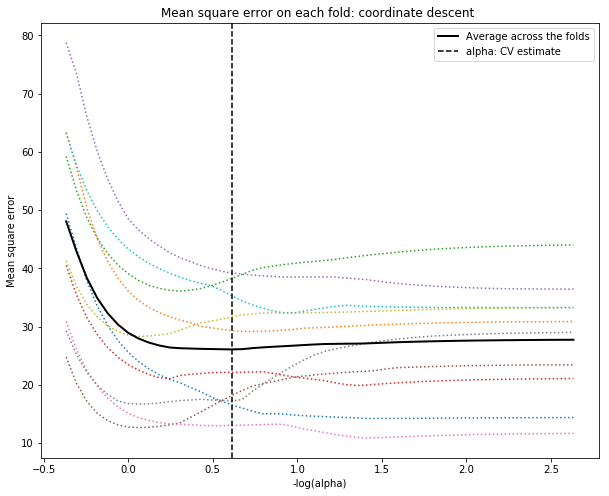

In [34]:
# Plotting MSE vs alphas
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(m_log_alphas, reg.mse_path_, ':')
plt.plot(m_log_alphas, reg.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(reg.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent ')         
plt.axis('tight')
plt.show()





##### This graph shows the mean squared error of every fold with dotted line and average mean squared error of k fold is shown in solid line.
The Vertical dotted black line choose optimum point having lowest bias and variance and this
is used as lambda penalty for shrinking coefficient. Log transformation is applied to reg.alpha to make it easily understandable

In [120]:
### Used LassoLarsCV model for lasso regularization and feature selection

In [99]:
from sklearn.linear_model import LassoLarsCV 
reg_lars = linear_model.LassoLarsCV(cv=10,max_n_alphas=50).fit(X_train,Y_train)


In [100]:
print (pd.DataFrame(list(zip(X_train.columns, reg_lars.coef_)),columns=['Features','Coeff']))

                      Features     Coeff
0                       Smoker  8.398610
1                       'Male'  0.000000
2  'St. Mary's Medical Center'  0.000000
3                'VA Hospital'  0.000000
4                       'Fair' -1.417348
5                       'Good'  0.000000
6                       'Poor'  0.000000
7                        Age_s  0.000000
8                     Height_s  0.000000
9                     Weight_s  0.000000


In [101]:
reg_lars.alpha_

0.093012757420789391

In [102]:
reg_lars.alphas_

array([ 0.54586742,  0.15457933,  0.09301276])

In [103]:

a = reg_lars.cv_alphas_


In [104]:
#The suggested alpha value  (reg_lars.alpha_)
a[38]

0.093012757420789391

In [ ]:

m_log_alphascv = -np.log10(reg_lars.cv_alphas_)
m_log_alphascv[38]

In [236]:
reg_lars.coef_path_

array([[  0.        ,  31.3030472 ,  35.82969505],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  -4.52664786],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ]])

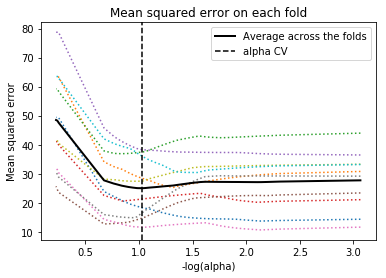

In [106]:
#plot mean square error for each fold
#fig, ax = plt.subplots(figsize=(30,6))



plt.figure()
plt.plot(m_log_alphascv, reg_lars.mse_path_, ':')
plt.plot(m_log_alphascv, reg_lars.mse_path_.mean(axis=-1), 'k',
        label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(reg_lars.alpha_), linestyle='--', color='k',
        label='alpha CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')
xmin = 0.1
xmax = 1.0
plt.xlim([0.1, 1.4])
xmin, xmax = plt.xlim()
plt.axis('tight')
plt.show()


This graph shows the mean squared error of every fold with dotted 
line and average mean squared error of k fold is shown in solid line.
The Vertical dotted black line choose optimum point having lowest bias and variance 
and this is used as  lambda penalty for shrinking coefficient.Transformation 
is applied to reg_lars.alpha_ to make it easily understandable

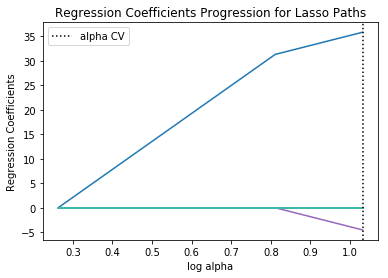

In [107]:
# plot coefficient progression
m_log_alphas = -np.log10(reg_lars.alphas_)
ax = plt.gca()
plt.plot(m_log_alphas, reg_lars.coef_path_.T)
plt.axvline(-np.log10(reg_lars.alpha_), linestyle= 'dotted', color='k',
label='alpha CV')
plt.ylabel('Regression Coefficients')
plt.legend()
plt.xlabel('log alpha')
plt.title('Regression Coefficients Progression for Lasso Paths')
plt.show()

In [110]:
#In LassoLarCV:
    
#The alpha value suggested is : 0.09301 ( The transformed value is 1.031 )

In [111]:
#Let us try to build a model using this alpha value 0.09301
from sklearn.model_selection import cross_val_score
lars_fit = linear_model.LassoLars(alpha=0.093012757420789391).fit(X_train,Y_train)
lars_fit.fit(X_train,Y_train)
score = cross_val_score(lars_fit,X_train,Y_train,cv=10)

print (pd.DataFrame(list(zip(X_train.columns, lars_fit.coef_)),columns=['Features','Coeff']))


                      Features     Coeff
0                       Smoker  8.398610
1                       'Male'  0.000000
2  'St. Mary's Medical Center'  0.000000
3                'VA Hospital'  0.000000
4                       'Fair' -1.417348
5                       'Good'  0.000000
6                       'Poor'  0.000000
7                        Age_s  0.000000
8                     Height_s  0.000000
9                     Weight_s  0.000000


In [112]:
lars_pred = lars_fit.predict(X_test)

In [118]:
from sklearn import metrics
MAE_test = metrics.mean_absolute_error(Y_test, lars_pred)
MAE_train = metrics.mean_absolute_error(Y_train, lars_fit.predict(X_train))
print("MAE test: ",MAE_test)
print("MAE train: ",MAE_train)
MSE_test = metrics.mean_squared_error(Y_test, lars_pred)
MSE_train = metrics.mean_squared_error(Y_train, lars_fit.predict(X_train))
print("MSE test: ",MSE_test)
print("MSE train: ",MSE_train)
RMSE_test = np.sqrt(MSE_test)
RMSE_train = np.sqrt(MSE_train)
print("RMSE test: ",RMSE_test)
print("RMSE train: ",RMSE_train)

MAE test:  3.58477279817
MAE train:  3.89013564357
MSE test:  18.3237426142
MSE train:  23.3067329744
RMSE test:  4.28062409167
RMSE train:  4.82770473149
